# Kevin Jin 
#### HW3 - Part I

Please do one of the following.


# Part I: Classification

1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col = 0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [2]:
df_default=pd.get_dummies(df['default'])
df_student=pd.get_dummies(df['student'])
df_final = pd.concat([df[['balance','income']],df_default, df_student],axis=1)

features = ['default', 'student']
for i in features:
    df[i] = df[i].astype('category')

df_final.columns = ['balance', 'income', 'default_No','default_Yes','student_No','student_Yes']
df_final.head()

,balance,income,default_No,default_Yes,student_No,student_Yes
1,729.526495,44361.625074,1,0,1,0
2,817.180407,12106.134700,1,0,0,1
3,1073.549164,31767.138947,1,0,1,0
4,529.250605,35704.493935,1,0,1,0
5,785.655883,38463.495879,1,0,1,0


- Dummy variables are created for both the Default and Student categorical Yes/No responses

3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

Text(0.5,1,'Boxplot with normal axis')

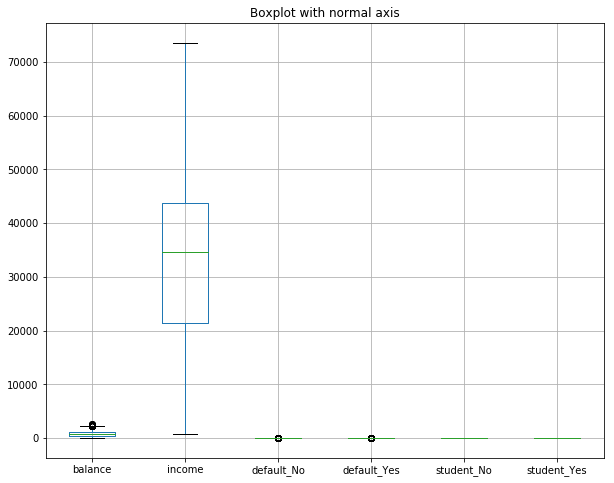

In [3]:
f1 = plt.figure(figsize=(10,8))
ax2 = f1.add_subplot(111)
ax2 = df_final.boxplot() #plots with regular axis
plt.title('Boxplot with normal axis')

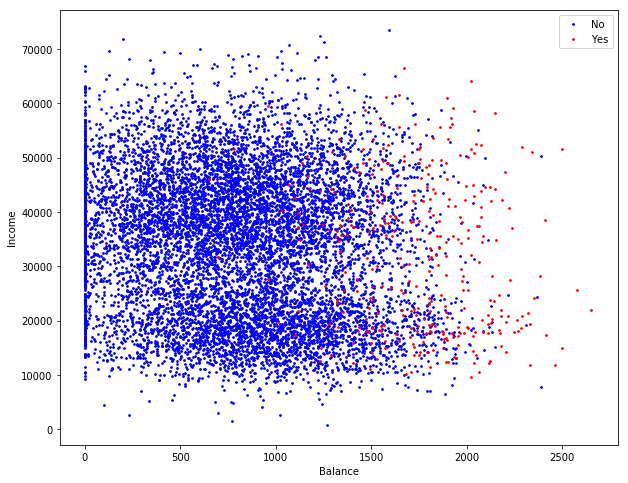

In [4]:
df1 = df_final
d_yes = df1['default_Yes'] == 1
d_no = df1['default_Yes'] == 0
df2 = df1[d_yes]
df3 = df1[d_no]


#create scatterplots
f3 = plt.figure(figsize=(10,8))
ax3 = f3.add_subplot(111)

ax3.scatter(df3['balance'],df3['income'], s=3,c = 'b', label = 'No')
ax3.scatter(df2['balance'],df2['income'], s=3,c = 'r', label = 'Yes')
plt.ylabel('Income')
plt.xlabel('Balance')
plt.legend(loc='upper right');

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

In [6]:
X = df[['balance','income']]
y = df_final['default_Yes']

normalize = StandardScaler()
X_std = normalize.fit_transform(X)

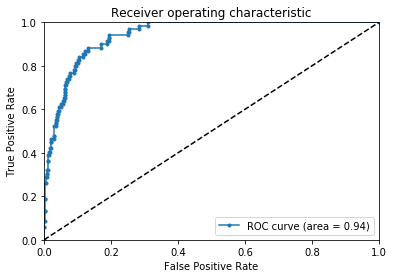

0.942516830658


In [7]:
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.20, random_state=42)
classifier = LogisticRegression(penalty='l1')
classifier.fit(X_train, y_train)
coeffs = classifier.coef_[0]
intercept = classifier.intercept_

y_predict_prob = classifier.predict_proba(X_test)
fpr,tpr,thresholds = roc_curve(y_test,y_predict_prob[:,1])
roc_auc = auc(fpr,tpr)      
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print(roc_auc)

Text(0,0.5,'Income')

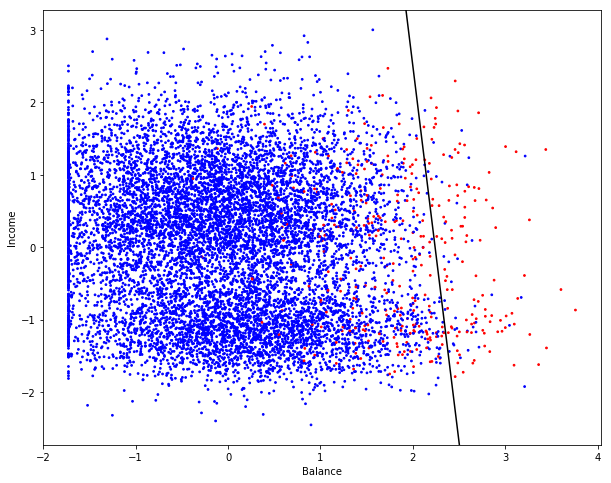

In [8]:
X2 = X_std.copy()
a = coeffs
b = intercept

colors= {0:"blue",1:"red"}

f4 = plt.figure(figsize=(10,8))
ax4 = f4.add_subplot(111)
ax4.scatter(X2[:,0],X2[:,1],s=3, c=df_final['default_Yes'].apply(lambda x:colors[x]))
x_min, x_max = ax4.get_xlim()
y_min, y_max = ax4.get_ylim()

x1=np.arange(1, 3, 0.1)
y=(b+a[0]*x1)/-a[1]
ax4.plot(x1,y, c='k')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel("Balance")
plt.ylabel("Income")

- By the looks of this ROC curve being 0.943, it is a very good method of classification

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

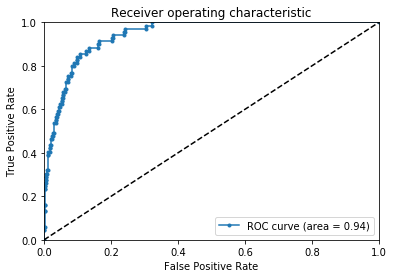

0.943522542199


In [9]:
#Repeat with student variables added: Used 2 dummy variables: Student yes and Student No
X = df_final[['balance','income','student_Yes', 'student_No']]
y = df_final['default_Yes']

normalize = StandardScaler()
X_std = normalize.fit_transform(X)

logistic = LogisticRegression(penalty = 'l1')
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.20, random_state=42)
logistic.fit(X_train,y_train)
y_predict_prob = logistic.predict_proba(X_test)
fpr,tpr,thresholds = roc_curve(y_test,y_predict_prob[:,1])
roc_auc = auc(fpr,tpr)      
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print(roc_auc)

- The AUC for the model with the added student variable is 0.944 which is only slightly higher than the one without the student variable.

In [10]:
#Function to find best penalty term iteratively for L2 regularization Logistic Regression

def generate_auc(X,y,**kwargs):
    # Construct training and testing set.
    X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.20, random_state=42)
    
    # Choose logistic regression classifier with arguments
    classifier = LogisticRegression(**kwargs)
    classifier.fit(X_train, y_train)
    probas_ = classifier.predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    #print "Area under the ROC curve : %f" % roc_auc
    return fpr, tpr, roc_auc, thresholds


0.169154216649
0.943627616539


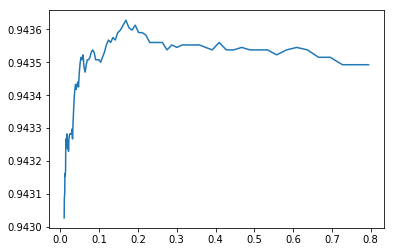

In [11]:
alphas = np.logspace(-2,-0.1,100)
scores = []
for i in alphas:
    logistic = LogisticRegression(C=i, penalty = 'l2')
    fpr,tpr,roc_auc,thresholds = generate_auc(X_std,y,C=i,penalty='l2')
    scores.append(roc_auc)


plt.plot(alphas,scores)
best_alpha = alphas[np.argmax(scores)]
print(best_alpha)
print(np.max(scores))

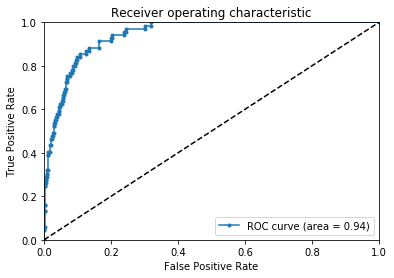

0.943627616539


In [12]:
logistic = LogisticRegression(C=best_alpha, penalty = 'l2')
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.20, random_state=42)
logistic.fit(X_train,y_train)
y_predict_prob = logistic.predict_proba(X_test)
fpr,tpr,thresholds = roc_curve(y_test,y_predict_prob[:,1])
roc_auc = auc(fpr,tpr)      
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print(roc_auc)

- The AUC for the best score with L2 (Ridge) regularization is roughly the same as above without L2 regularization, but is slightly greater at 0.9436 instead of 0.9435. It is seen that there is not much of an effect on the model when the additional variable is added with a ridge regression L2 penalty.

[ 2.14625839  0.08146042 -0.07104261  0.07104261]


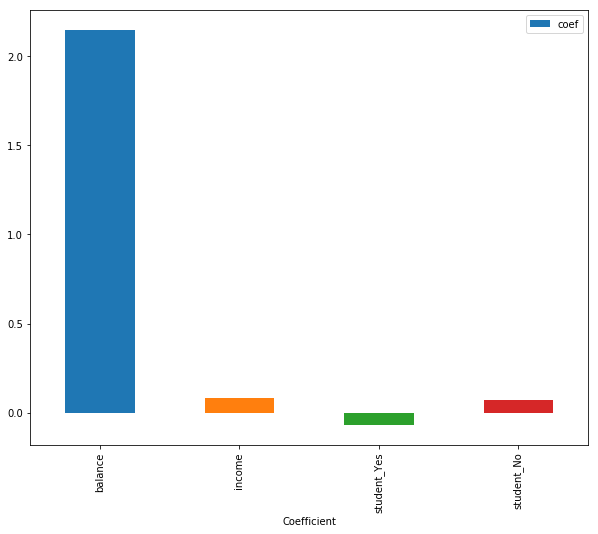

In [13]:
#Plot ranking of coefficients
regr = LogisticRegression(C=best_alpha,penalty='l2')
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)
regr.fit(X_train,y_train)

coeff = regr.coef_[0]
df_coefficient = pd.DataFrame({'type':X.columns.values, 'coef':coeff})
df_coefficient.plot(x='type',y='coef',kind='bar',figsize=(10,8))
plt.xlabel('Coefficient')
print(coeff)

 - Here, it is shown that the balance is the most important coefficient, while income is the least relevant coefficient. It is shown that whether or not they are a student (yes/no) generally has a negative impact on the model meaning they are more likely to default if they are a student. As expected, the variables generated for the student differ in sign because they are opposites of each other.

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

Text(0.5,1,'ROC Curve')

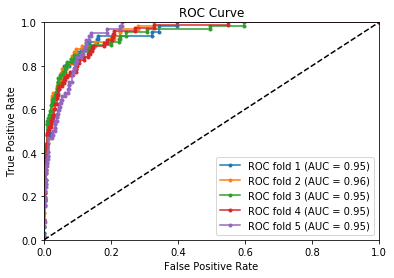

In [14]:
from sklearn.model_selection import KFold
X_std_kf = np.array(X_std)
y_kf = np.array(y)

kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X_std)
coeffs = []

i = 1
for train_index, test_index in kf.split(X_std):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_std_kf[train_index], X_std_kf[test_index]
    y_train, y_test = y_kf[train_index], y_kf[test_index]
    classifier = LogisticRegression(C=best_alpha,penalty='l2')
    classifier.fit(X_train,y_train)
    y_predict_prob = classifier.predict_proba(X_test)
    coef = classifier.coef_
    fpr,tpr,thresholds = roc_curve(y_test,y_predict_prob[:,1])
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr, '.-',
             label='ROC fold %i (AUC = %0.2f)' % (i,roc_auc))
    plt.legend(loc="lower right")
    coeffs.append(coef)
    i += 1

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

- With a 5 fold cross validation, it is shown that each fold ranges from 0.95 to 0.96 which matches the test-train split method above. Therefore, it can be concluded that this is a robust model.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

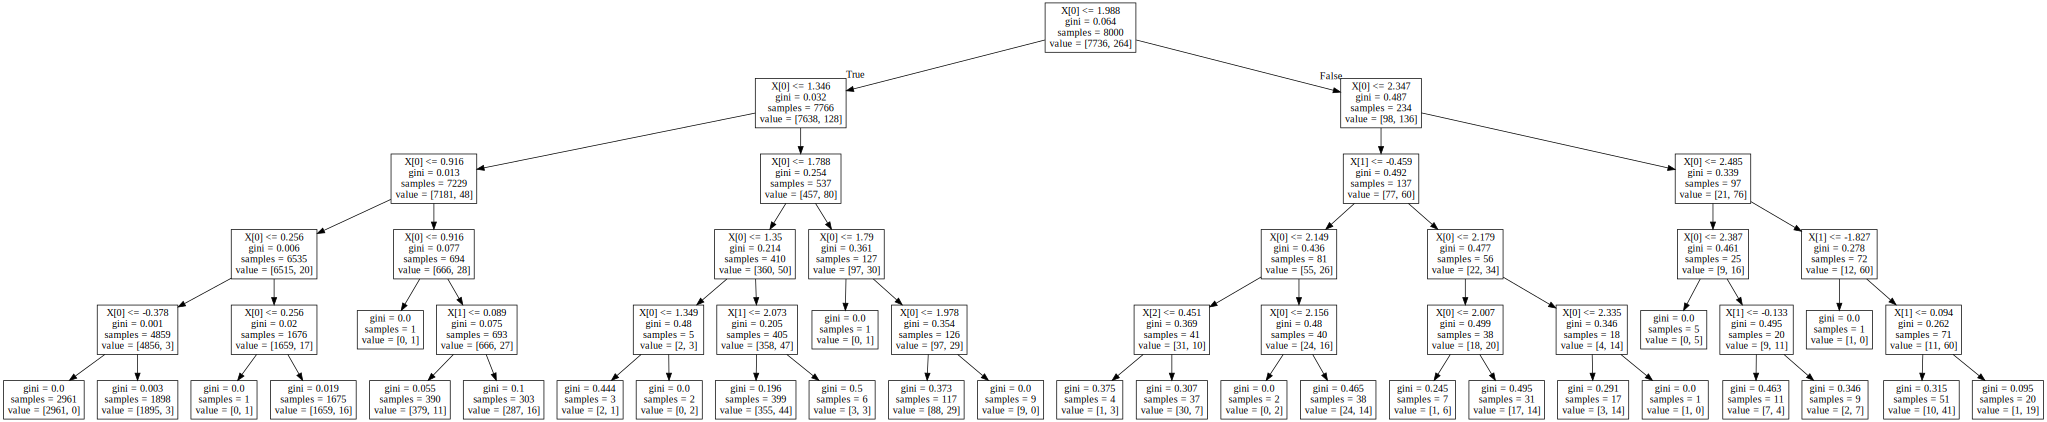

In [15]:
from sklearn import tree
from IPython.display import Image
df_tree = X_std
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)
classifier = tree.DecisionTreeClassifier(max_depth=5)
classifier.fit(X_train,y_train)

import graphviz
dot_data = tree.export_graphviz(classifier, out_file=None)
graph = graphviz.Source(dot_data)
graph

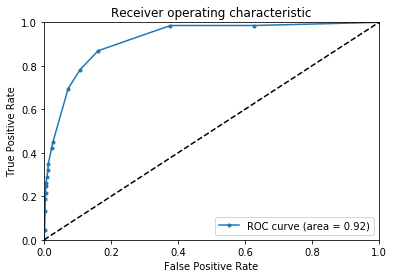

0.921757143179


In [16]:
y_pred_prob = classifier.predict_proba(X_test)
fpr,tpr,thresholds = roc_curve(y_test,y_pred_prob[:,1])
roc_auc = auc(fpr,tpr)    
    
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print(roc_auc)

- With a depth of 5, it is shown that the decision tree has a lower AUC than the Logistic Regression classifier. This means this model is not as accurate as the previous one.

8) Find the optimal decision tree depth and compute the AUC ROC. 

4.0
0.932549778969


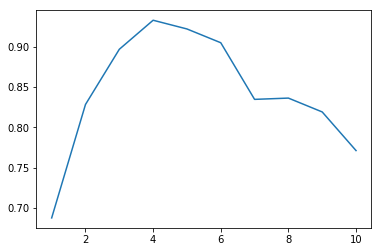

In [17]:
def generate_auc_tree(X,y,tree_depth):
    # Construct training and testing set.
    X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)
    
    # Choose SVC classifier.
    classifier = tree.DecisionTreeClassifier(max_depth=tree_depth)
    classifier.fit(X_train, y_train)
    probas_ = classifier.predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc, thresholds

depths = (np.linspace(1,10,10))
depths.astype(int)

tree_scores = []
for depth in depths:
    fpr,tpr,roc_auc,thresholds = generate_auc_tree(X,y,depth)
    tree_scores.append(roc_auc)

plt.plot(depths,tree_scores)
best_depth = depths[np.argmax(tree_scores)]
print(best_depth)
print(np.max(tree_scores)) #AUC

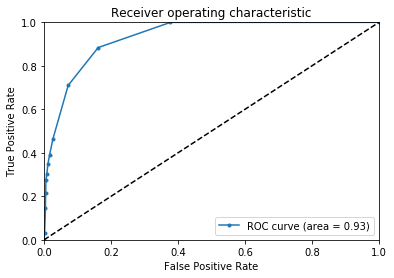

0.932549778969


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)
classifier = tree.DecisionTreeClassifier(max_depth=best_depth)
classifier.fit(X_train,y_train)
y_pred_prob = classifier.predict_proba(X_test)
fpr,tpr,thresholds = roc_curve(y_test,y_pred_prob[:,1])
roc_auc = auc(fpr,tpr)    

generate_ROCplot(fpr,tpr,'LR',roc_auc)
print(roc_auc)

- It is shown that the best decision tree is with a depth of 4, and the AUC is similar to that of the Logistic Regression Model but is slightly lower than the model with no added Student variable. The decision tree with depth of 4 has an AUC value slightly higher than that of the first decision tree classifier with depth of 5.

# Part II: Recommendation Systems.  
- (Only did Part I)

In this problem we will use the notebook https://github.com/Columbia-Intro-Data-Science/APMAE4990-/blob/master/notebooks/matrix_factorization_recommender.ipynb  as
a starting point.

1) Split the ratings matrix `R_df` into training and testing sets. Remember we need to do this for rows and columns now. 

2) Evaluate the performance of the matrix factorization model for $K=50$. In particular, measure the:
 - Precision.
 - Recall. 

You can round up or down to the nearest integer for the ratings. 

3) Construct an item/item and user/user model, and evaluate the performance as in 2). How does it compare?

4) Check how your answer to 3) changes (if at all) as you try different values of K for K=10, 20, 100. 